In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

Read Dataset

In [2]:
df = pd.read_csv('all_data.csv',delimiter=',',encoding='latin-1')
df.head()


,Positive,Apple announced plans to achieve carbon neutrality by 2030.
0,Positive,New solar panel technology could revolutionize...
1,Negative,Tech giants need to prioritize e-waste reduction.
2,Negative,Google's AI ethics committee faces criticism o...
3,Positive,Tesla's electric vehicles are driving the shif...
4,Negative,Amazon's data centers consume enormous amounts...


In [3]:
df.tail()

,Positive,Apple announced plans to achieve carbon neutrality by 2030.
176,Neutral,Public-private partnerships drive sustainable ...
177,Neutral,Debates over the ethical use of facial recogni...
178,Neutral,Tech's role in disaster response and recovery ...
179,Neutral,Sustainable fashion initiatives focus on consu...
180,Neutral,Tech companies collaborate on open-source sust...


In [4]:
df = df.rename(columns={'Positive':'sentiment', 'Apple announced plans to achieve carbon neutrality by 2030.':'Message'})

In [5]:
df.shape

(181, 2)

In [6]:
df.index = range(181)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

1405

VISUALIZING THE DATA

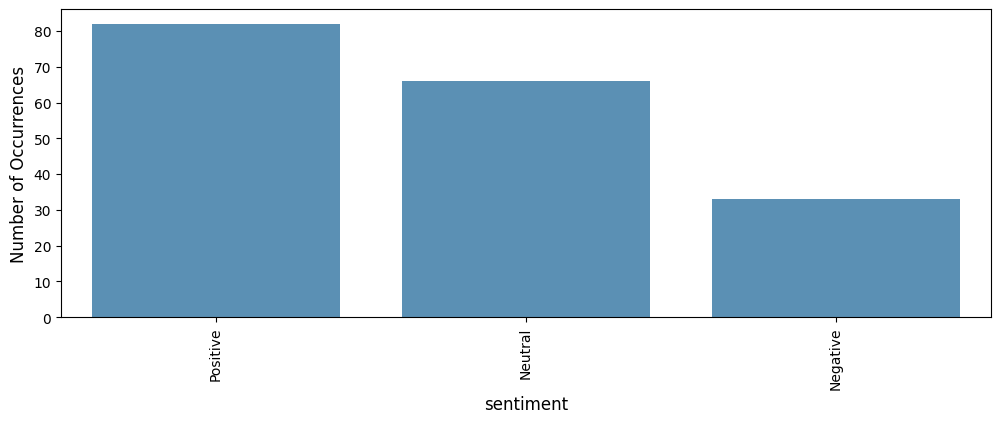

In [7]:
cnt_pro = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [8]:
#Convert sting to numeric
sentiment  = {'Positive': 0,'Neutral': 1,'Negative':2}

df.sentiment = [sentiment[item] for item in df.sentiment]
print(df)

     sentiment                                            Message
0            0  New solar panel technology could revolutionize...
1            2  Tech giants need to prioritize e-waste reduction.
2            2  Google's AI ethics committee faces criticism o...
3            0  Tesla's electric vehicles are driving the shif...
4            2  Amazon's data centers consume enormous amounts...
..         ...                                                ...
176          1  Public-private partnerships drive sustainable ...
177          1  Debates over the ethical use of facial recogni...
178          1  Tech's role in disaster response and recovery ...
179          1  Sustainable fashion initiatives focus on consu...
180          1  Tech companies collaborate on open-source sust...

[181 rows x 2 columns]


In [9]:
def print_message(index):
    example = df[df.index == index][['Message', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

IBM is investing in quantum computing for climate research.
Message: 0


In [10]:
print_message(0)

New solar panel technology could revolutionize renewable energy.
Message: 0


Text Preprocessing Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [11]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text)
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
df['Message'] = df['Message'].apply(cleanText)
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 181 unique tokens.


In [14]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (181, 50)


In [15]:
#train_tagged.values[2173]
train_tagged.values

array([TaggedDocument(words=['google', "'s", 'commitment', 'to', 'zero', 'waste', 'initiatives', 'is', 'inspiring', '.'], tags=[0]),
       TaggedDocument(words=['ai', "'s", 'role', 'in', 'combating', 'climate', 'change', 'is', 'evolving', '.'], tags=[1]),
       TaggedDocument(words=['the', 'carbon', 'footprint', 'of', 'cloud', 'gaming', 'platforms', 'is', 'a', 'concern', '.'], tags=[2]),
       TaggedDocument(words=['the', 'impact', 'of', '5g', 'on', 'sustainability', 'is', 'debated', '.'], tags=[1]),
       TaggedDocument(words=['climate', 'change', 'poses', 'risks', 'to', 'tech', 'infrastructure', '.'], tags=[2]),
       TaggedDocument(words=['green', 'computing', 'initiatives', 'are', 'essential', 'for', 'a', 'sustainable', 'future', '.'], tags=[0]),
       TaggedDocument(words=['the', 'tech', 'sector', 'must', 'address', 'the', 'environmental', 'impact', 'of', 'hardware', 'production', '.'], tags=[2]),
       TaggedDocument(words=['tech', 'companies', 'invest', 'in', 'renewable',

Model DM = 1

This work use DM=1 (it preserve word order)

In [16]:
# d2v_model = Doc2Vec(dm=1, dm_mean=1, size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])


100%|██████████| 180/180 [00:00<00:00, 652527.85it/s]


In [17]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 180/180 [00:00<00:00, 861843.29it/s]


CPU times: user 615 ms, sys: 37.6 ms, total: 652 ms
Wall time: 828 ms


In [18]:
print(d2v_model)

Doc2Vec<dm/m,d20,n5,w8,s0.001>


In [19]:
d2v_model.wv.index_to_key

['.',
 'in',
 'tech',
 'the',
 'energy',
 'are',
 'of',
 'is',
 'renewable',
 'to',
 'companies',
 'ai',
 'on',
 'data',
 'sustainable',
 "'s",
 'impact',
 'carbon',
 'technology',
 'can',
 'a',
 'sustainability',
 'for',
 'environmental',
 'initiatives',
 'blockchain',
 'over',
 'green',
 'management',
 'ethical',
 'smart',
 'supply',
 'climate',
 'gaining',
 'concerns',
 'by',
 'footprint',
 'industry',
 'challenges',
 'adoption',
 'face',
 'transparency',
 'role',
 'efficiency',
 'reduce',
 'public',
 'electric',
 'waste',
 'practices',
 'and',
 'centers',
 'infrastructure',
 'startups',
 'optimize',
 'invest',
 'solutions',
 'chain',
 'privacy',
 'cloud',
 'more',
 'efforts',
 'future',
 'projects',
 'development',
 'use',
 'persist',
 'packaging',
 'policies',
 'vary',
 'innovations',
 'vehicles',
 'should',
 'traction',
 'consumer',
 'healthcare',
 'google',
 'wildlife',
 'debate',
 'commitment',
 'sources',
 'concern',
 'debated',
 'computing',
 'need',
 'address',
 'production'

In [20]:
d2v_model.dv.vectors

array([[-2.6512418 , -2.727615  , -1.7408246 ,  4.5851345 ,  0.2782448 ,
        -0.44055864, -6.0780153 , -0.89151525, -5.489114  ,  1.5215937 ,
         0.4477373 ,  1.4796101 ,  0.38598093,  0.32335195, -0.94549066,
        -6.717244  ,  1.0260522 ,  4.867299  , -4.499227  , -4.162951  ],
       [-2.2649493 ,  0.46333018, -3.6143796 ,  4.650686  ,  5.427221  ,
        -2.771485  , -2.147992  , -3.027275  , -0.6554688 , -4.35361   ,
         4.597008  ,  2.677166  , -3.3273218 , -2.8552802 , -0.30698785,
         1.795212  ,  2.7042572 , -4.0318623 , -2.193751  ,  2.0892408 ],
       [-2.5446095 , -6.029582  ,  2.2255228 , -1.5291418 ,  0.48612046,
        -2.8429675 , -0.8229828 , -0.68818945, -3.322086  , -1.966732  ,
         3.6353512 ,  0.527922  , -4.809867  , -5.983405  , -1.3346839 ,
         5.8058667 ,  1.4945606 ,  4.412099  , -6.5590405 ,  0.98942935]],
      dtype=float32)

In [21]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.index_to_key)+ 1, 20))

for i, vec in enumerate(d2v_model.dv.vectors):
    while i in vec <= 100:
    #print(i)
    #print(model.docvecs)
          embedding_matrix[i]=vec
    #print(vec)
    #print(vec[i])

# Measuring distance between two vectors (related to cosine similarity)

In [22]:
d2v_model.wv.most_similar(positive=['energy-efficient'], topn=10)

[('appliances', 0.87519371509552),
 ('facebook', 0.8738319873809814),
 ('practices', 0.865057110786438),
 ('solutions', 0.8635282516479492),
 ('gadgets', 0.860425591468811),
 ('reshaping', 0.8567269444465637),
 ('financial', 0.8553938865661621),
 ('gaining', 0.8449129462242126),
 ('consumption', 0.8404158353805542),
 ('promising', 0.837714433670044)]

In [23]:
d2v_model.wv.most_similar(positive=['investment'], topn=10)

[('awareness', 0.8959972858428955),
 ('issues', 0.8846880197525024),
 ('smartphone', 0.8846154808998108),
 ('use', 0.882526695728302),
 ('implications', 0.8818418979644775),
 ('affect', 0.8747193217277527),
 ('concerning', 0.874009370803833),
 ('continue', 0.8736481070518494),
 ('epansion', 0.8708701133728027),
 ('charging', 0.8692067861557007)]

In [24]:
d2v_model.wv.most_similar(positive=['zero-waste'], topn=10)

[('priority', 0.7781924605369568),
 ('cloud', 0.7655738592147827),
 ('moving', 0.7560240626335144),
 ('mining', 0.7499487996101379),
 ('cryptocurrency', 0.7331640720367432),
 ('its', 0.6996006369590759),
 ('pressure', 0.6954761147499084),
 ('evaluation', 0.672150194644928),
 ('environmental', 0.6626198291778564),
 ('footprint', 0.6621782183647156)]

Plot Similarity word in Doc2vec

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in d2v_model.wv.key_to_index:
        tokens.append(model[word])
        labels.append(word)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [26]:
# tsne_plot(d2v_model)

# Create the LSTM Model

The parameter used here inspired by [3].



In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.index_to_key)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 20)            8140      
                                                                 
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 22493 (87.86 KB)
Trainable params: 22493 (87.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


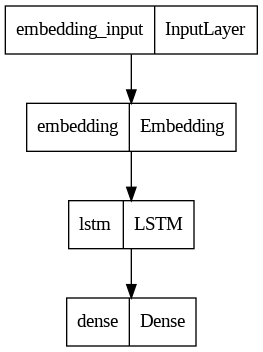

In [28]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [29]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(153, 50) (153, 3)
(28, 50) (28, 3)


In [30]:
vocab_size = len(d2v_model.wv.index_to_key) + 1
print(vocab_size)

407


In [58]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)

# predict crisp classes for test set
yhat_classes = model.predict(X_test, verbose=0).argmax(axis=1)

# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1]

In [33]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([2, 0, 1, 2, 1, 2, 0, 2, 0, 0, 0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0])

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[15,  0,  0],
       [ 8,  0,  0],
       [ 5,  0,  0]])

In [35]:
yhat_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [36]:
rounded_labels

array([2, 0, 1, 2, 1, 2, 0, 2, 0, 0, 0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0])

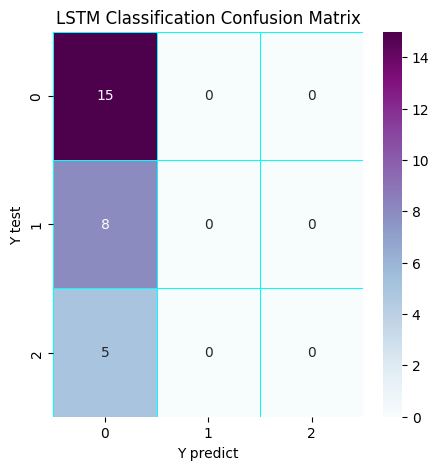

In [37]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

# Validation

**Save Model**


In [38]:
model.save('Mymodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Test with new and different data set aside from the data to build the model.**

note : sentiment  = {'positive': 0,'neutral': 1,'negative':2}

In [54]:
message = ['Data centers powered by renewable energy sources are more sustainable']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 25ms/step
[[0.33333334 0.33333334 0.33333334]] 0


In [59]:
print("The rating of the 'IDEA' is :",pred*100)

The rating of the 'IDEA' is : [[33.333336 33.333336 33.333336]]
